In [8]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pyvinecopulib as pv
from gcimpute.gaussian_copula import GaussianCopula
from gcimpute.helper_evaluation import get_smae

In [2]:
def get_ced_cing(T, cop=None):
    d = T.shape[1]
    cing = []
    ced = []
    param = []
    for j in range(d):
        for i1 in range(d-j-1):
            ced.append(sorted((T[i1,j], T[d-j-1, j])))
            tmp = []
            for i2 in range(i1):
                tmp.append(T[i2,j])
            cing.append(sorted(tmp))
            if cop is not None:
                param.append(cop.get_parameters(i1, j)[0][0])
    return ced, cing, param

def find(a, cing_len, ced, cing):
    out = [i for i in range(len(ced)) if a in ced[i]]
    matched = False
    for i in out:
        if len(cing[i]) == cing_len:
            matched = True
            break
    assert matched, f'bad argument, a={a}, cing_len={cing_len}'
    return ced[i][1] if ced[i][0] == a else ced[i][0]

def diagonalize(T1, a):
    d = T1.shape[1]
    if a == T1[d-1, 0]:
        return T1
    assert a == T1[d-2, 0], f'cannot be diagonalized with {a}'

    T2 = np.zeros(shape=T1.shape, dtype=np.uint64)
    T2[d-1, 0] = a
    order = [a]

    ced, cing, _ = get_ced_cing(T1)
    for j in range(d-1):
        for i in range(d-j-1):
            T2[i,j] = find(T2[d-j-1, j], i, ced, cing)

        remove_idx = [i for i, c in enumerate(ced) for k in order if k in c]
        keep_idx = set(range(len(ced))).difference(set(remove_idx))

        ced = [ced[i] for i in keep_idx]
        cing = [cing[i] for i in keep_idx]

        T2[d-j-2, j+1] = T2[d-j-2, j]
        order.append(T2[d-j-2, j+1])
    return T2

def make_diagonal_copula(cop1, a):
    T1 = cop1.matrix
    d = T1.shape[0]
    ced, cing, param = get_ced_cing(T1, cop1)

    T2 = diagonalize(T1, a)

    pair_copulas = []
    for t in range(d-1):
        cur = []
        pair_copulas.append(cur)
        for e in range(d-1-t):
            cur.append(
                pv.Bicop(
                    family=pv.BicopFamily.gaussian,
                    parameters=[param[ced.index(sorted((T2[d-1-e,e], T2[t,e])))]]
                )
            )
    cop2 = pv.Vinecop(matrix=T2, pair_copulas=pair_copulas)
    return cop2

def expand(a_vec):
    if len(a_vec.shape) == 2:
        return a_vec
    else:
        return a_vec[:, None]

def get(U, i):
    assert i >= 1
    assert len(U.shape) == 2
    assert i <= U.shape[1]
    return expand(U[:,int(i-1)])

def calc_V_mat(U, cop, max_colidx):
    d = U.shape[1]
    
    # empty V matrix
    V = []
    for i in range(d):
        tmp = []
        V.append(tmp)
        for j in range(d):
            tmp.append(np.nan)

    for j in range(max_colidx):
        V[0][j] = get(U, cop.matrix[j, d-j-1])
        print(f'V({0},{j}) - {cop.matrix[j, d-j-1]}')
        for i in range(1, j+1):
            t = i-1
            e = d-1-j
            bicop = cop.get_pair_copula(t,e)
            V[i][j] = expand(bicop.hfunc2(np.hstack([V[i-1][j], V[i-1][i-1]])))
            print(f'V({i},{j}) = [({i-1},{j}), ({i-1},{i-1})] - {cop.matrix[d-1-e, e]},{cop.matrix[t,e]}')
    return V

def impute_corner(cop, V, n, d):
    u_imp = expand(np.random.uniform(size=n))
    for i in range(d-1)[::-1]:
        print(i, cop.get_pair_copula(i,0).parameters[0][0])
        u_imp = expand(cop.get_pair_copula(i,0).hinv2(np.hstack([u_imp, V[i][i]])))
    return u_imp

def compare(n,d,p):
    structure = pv.CVineStructure.simulate(d)

    pair_copulas = []
    for i in range(d-1):
        tmp = []
        pair_copulas.append(tmp)
        for j in range(d-i-1):
            rho = np.minimum(np.maximum(np.random.beta(1, 0.75), 0.01), 0.99)
            tmp.append(pv.Bicop(family=pv.BicopFamily.gaussian, parameters=[[rho]]))

    cop = pv.Vinecop(structure, pair_copulas)

    U = cop.simulate(n=n, seeds=list(1+np.arange(d)))
    v_idx = cop.matrix[d-1,0]

    missing = np.random.binomial(n=1, p=p, size=U.shape[0])

    U_mask = np.copy(U)
    v_mask = get(U_mask, v_idx)
    v_mask[missing == 1] = np.nan

    V = calc_V_mat(U, cop, d-1)
    U_imp1 = np.copy(U_mask)
    v_imp = get(U_imp1, v_idx)
    v_imp[missing == 1] = impute_corner(cop, V, n, d)[missing == 1]

    smae1 = get_smae(U_imp1, U, U_mask)[int(v_idx - 1)]
    re1 = (np.linalg.norm(np.corrcoef(U_imp1.T) - np.corrcoef(U.T), ord='fro') / 
             np.linalg.norm(np.corrcoef(U.T), ord='fro'))

    model = GaussianCopula()
    U_imp2 = model.fit_transform(X=U_mask)
    smae2 = get_smae(U_imp2, U, U_mask)[int(v_idx - 1)]
    re2 = (np.linalg.norm(np.corrcoef(U_imp2.T) - np.corrcoef(U.T), ord='fro') / 
             np.linalg.norm(np.corrcoef(U.T), ord='fro'))

    return smae1, smae2, re1, re2

In [3]:
%%capture
n = 1000
R = 100
out = []
start = time.time()
for d in range(4, 9):
    for p in np.arange(0.01, 0.1, 0.01):
        for _ in range(R):
            smae1, smae2, re1, re2 = compare(n,d,p)
            out.append((d,p,smae1,smae2,re1,re2))
end = time.time() - start
print((end-start)/60)

In [4]:
df = pd.DataFrame(out,columns=['d','p','smae1','smae2','re1','re2'])
df.to_pickle('tmp.pkl')

In [5]:
out = {}
for d in df['d'].unique():
    smae1 = []
    smae2 = []
    re1 = []
    re2 = []
    for p in df['p'].unique():
        smae1.append(df[(df['d'] == d) & (df['p'] == p)]['smae1'].to_list())
        smae2.append(df[(df['d'] == d) & (df['p'] == p)]['smae2'].to_list())
        re1.append(df[(df['d'] == d) & (df['p'] == p)]['re1'].to_list())
        re2.append(df[(df['d'] == d) & (df['p'] == p)]['re2'].to_list())
    out[d] = (smae1, smae2, re1, re2)

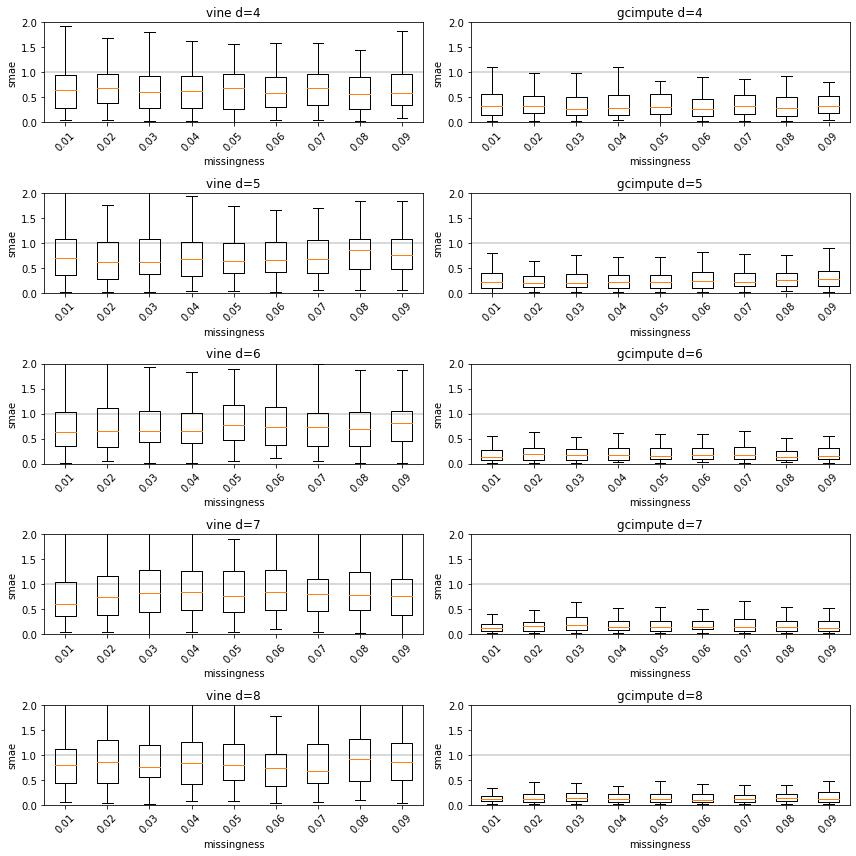

In [6]:
fig, axes = plt.subplots(5,2,figsize=(12,12),facecolor='white')
for i, d in enumerate(out.keys()):
    axes[i][0].boxplot(out[d][0], showfliers=False)
    axes[i][1].boxplot(out[d][1], showfliers=False)
    axes[i][0].axhline(1, color='k', alpha=0.2)
    axes[i][1].axhline(1, color='k', alpha=0.2)
    axes[i][0].set_ylim([0,2])
    axes[i][1].set_ylim([0,2])
plt.subplots_adjust(hspace=0.5, wspace=0.15)
xlabs = [f'{x:.2f}' for x in df['p'].unique()]
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(1+np.arange(len(xlabs)), xlabs, rotation=45)
    ax.set_ylabel('smae')
    ax.set_xlabel('missingness')
for i, d in enumerate(out.keys()):
    axes[i][0].set_title(f'vine d={d}')
    axes[i][1].set_title(f'gcimpute d={d}')
plt.tight_layout()
plt.savefig('vine_vs_gcimpute_smae.png', dpi=300)

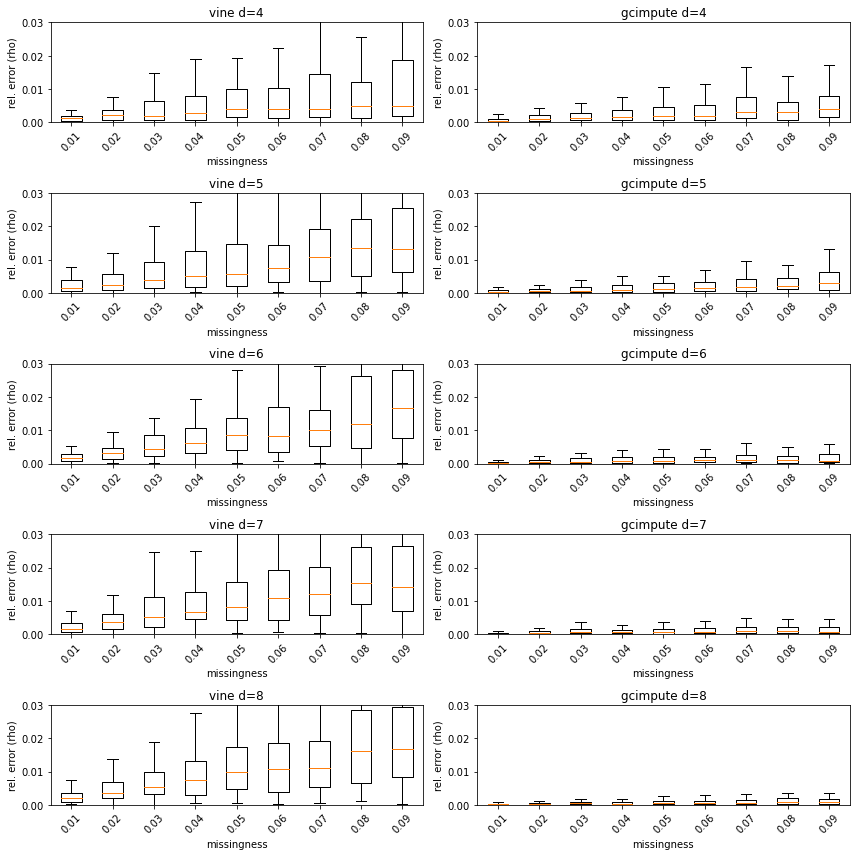

In [7]:
fig, axes = plt.subplots(5,2,figsize=(12,12),facecolor='white')
for i, d in enumerate(out.keys()):
    axes[i][0].boxplot(out[d][2], showfliers=False)
    axes[i][1].boxplot(out[d][3], showfliers=False)
    axes[i][0].set_ylim([0,0.03])
    axes[i][1].set_ylim([0,0.03])
plt.subplots_adjust(hspace=0.5, wspace=0.15)
xlabs = [f'{x:.2f}' for x in df['p'].unique()]
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(1+np.arange(len(xlabs)), xlabs, rotation=45)
    ax.set_ylabel('rel. error (rho)')
    ax.set_xlabel('missingness')
for i, d in enumerate(out.keys()):
    axes[i][0].set_title(f'vine d={d}')
    axes[i][1].set_title(f'gcimpute d={d}')
plt.tight_layout()
plt.savefig('vine_vs_gcimpute_relerror.png', dpi=300)